# Дерева рішень. Класифікація

---
<a name="0"/>

### Зміст:

* 1. [Імпорт даних](#1)
* 2. [Первинний аналіз](#2)
* 3. [Фіча інжинірінг](#3)
* 4. [Маштабування фіч](#4)
* 5. [Поділ датасету на train, test](#5)
* 6. [Тренування базової моделі(гіперпараметри=дефолтні)](#6)
* 7. [Підбір гіперпараметрів](#7)
* 8. [Оцінка результатів](#8)


---
Встановлення бібліотек

In [2]:
!pip install category_encoders

---
Імпортування бібліотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from category_encoders import BaseNEncoder

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

---
Загальні налаштування

In [4]:
# Налаштуваня візуалізація
sns.set()
%config InlineBackend.figure_format = 'svg'

# Ігнорування помилок при побудові моделі
warnings.filterwarnings("ignore")

---
<a name="1"/>

### 1. Імпорт даних
[зміст](#0)

In [5]:
url = 'https://archive.ics.uci.edu/static/public/27/credit+approval.zip'

In [7]:
resp = urlopen(url)
myzip = ZipFile(BytesIO(resp.read()))
with myzip.open('crx.data') as myfile:
    data = pd.read_csv(myfile, delimiter=',',
                       names = ['A1', 'A2', 'A3', 'A4',
                                'A5', 'A6', 'A7', 'A8',
                                'A9', 'A10', 'A11', 'A12',
                                'A13', 'A14', 'A15', 'A16'])

In [8]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


Опис датасету:

Цей датасет стосується заявок на кредитні картки. Усі назви та значення атрибутів було змінено на безглузді символи, щоб захистити конфіденційність даних. Цей набір даних цікавий тим, що в ньому добре поєднується атрибути: безперервні, номінальні з невеликою кількістю значень і номінальні з більшою кількістю значень. Є також кілька відсутніх значень.

`A16 - target`

---
<a name="2"/>

### 2. Первинний аналіз
[зміст](#0)

Перевірка дублікатів

In [9]:
data.duplicated().sum()

0

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    object 
 1   A2      690 non-null    object 
 2   A3      690 non-null    float64
 3   A4      690 non-null    object 
 4   A5      690 non-null    object 
 5   A6      690 non-null    object 
 6   A7      690 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 non-null    object 
 9   A10     690 non-null    object 
 10  A11     690 non-null    int64  
 11  A12     690 non-null    object 
 12  A13     690 non-null    object 
 13  A14     690 non-null    object 
 14  A15     690 non-null    int64  
 15  A16     690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [11]:
data.describe(include='all')

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
count,690,690,690.000000,690,690,690,690,690.000000,690,690,690.00000,690,690,690,690.000000,690
unique,3,350,NaN,4,4,15,10,NaN,2,2,NaN,2,3,171,NaN,2
top,b,?,NaN,u,g,c,v,NaN,t,f,NaN,f,g,00000,NaN,-
freq,468,12,NaN,519,519,137,399,NaN,361,395,NaN,374,625,132,NaN,383
mean,NaN,NaN,4.758725,NaN,NaN,NaN,NaN,2.223406,NaN,NaN,2.40000,NaN,NaN,NaN,1017.385507,NaN
std,NaN,NaN,4.978163,NaN,NaN,NaN,NaN,3.346513,NaN,NaN,4.86294,NaN,NaN,NaN,5210.102598,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.00000,NaN,NaN,NaN,5.000000,NaN
75%,NaN,NaN,7.207500,NaN,NaN,NaN,NaN,2.625000,NaN,NaN,3.00000,NaN,NaN,NaN,395.500000,NaN


Видно, що серед категоріальних фіч є невизначені `"?"`. А серед кількісних є `0`. Замінимо невизначені - найпоширенішим у фічі, а `0` - середнім значеням по фічі.

Та ще

`A2 - float` <br>
`A3 - float` <br>
`A8 - float` <br>
`A14 - category` <br>
`A15 - int` <br>

In [12]:
data['A1'].value_counts()

b    468
a    210
?     12
Name: A1, dtype: int64

In [13]:
data['A1'] = data['A1'].replace('?', 'b')

In [14]:
data['A2'].value_counts()

?        12
22.67     9
20.42     7
18.83     6
24.50     6
         ..
48.25     1
28.33     1
18.75     1
18.50     1
36.42     1
Name: A2, Length: 350, dtype: int64

In [15]:
data['A2'] = data['A2'].replace('?', 0.0)

In [16]:
data['A2'] = data['A2'].astype('float16')

In [17]:
data['A2'] = data['A2'].replace(0.0, data['A2'].mean())

In [18]:
data['A4'].value_counts()

u    519
y    163
?      6
l      2
Name: A4, dtype: int64

In [19]:
data['A4'] = data['A4'].replace('?', 'u')

In [20]:
data['A5'].value_counts()

g     519
p     163
?       6
gg      2
Name: A5, dtype: int64

In [21]:
data['A5'] = data['A5'].replace('?', 'g')

In [22]:
data['A6'].value_counts()

c     137
q      78
w      64
i      59
aa     54
ff     53
k      51
cc     41
m      38
x      38
d      30
e      25
j      10
?       9
r       3
Name: A6, dtype: int64

In [23]:
data['A6'] = data['A6'].replace('?', 'c')

In [24]:
data['A7'].value_counts()

v     399
h     138
bb     59
ff     57
?       9
j       8
z       8
dd      6
n       4
o       2
Name: A7, dtype: int64

In [25]:
data['A7'] = data['A7'].replace('?', 'v')

In [26]:
data.describe(include='all')

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
count,690,690.000000,690.000000,690,690,690,690,690.000000,690,690,690.00000,690,690,690,690.000000,690
unique,2,NaN,NaN,3,3,14,9,NaN,2,2,NaN,2,3,171,NaN,2
top,b,NaN,NaN,u,g,c,v,NaN,t,f,NaN,f,g,00000,NaN,-
freq,480,NaN,NaN,525,525,146,408,NaN,361,395,NaN,374,625,132,NaN,383
mean,NaN,31.562500,4.758725,NaN,NaN,NaN,NaN,2.223406,NaN,NaN,2.40000,NaN,NaN,NaN,1017.385507,NaN
std,NaN,11.851562,4.978163,NaN,NaN,NaN,NaN,3.346513,NaN,NaN,4.86294,NaN,NaN,NaN,5210.102598,NaN
min,NaN,13.750000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,22.671875,1.000000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
50%,NaN,28.625000,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.00000,NaN,NaN,NaN,5.000000,NaN
75%,NaN,37.710938,7.207500,NaN,NaN,NaN,NaN,2.625000,NaN,NaN,3.00000,NaN,NaN,NaN,395.500000,NaN


---
<a name="3"/>

### 3. Фіча інжинірінг
[зміст](#0)

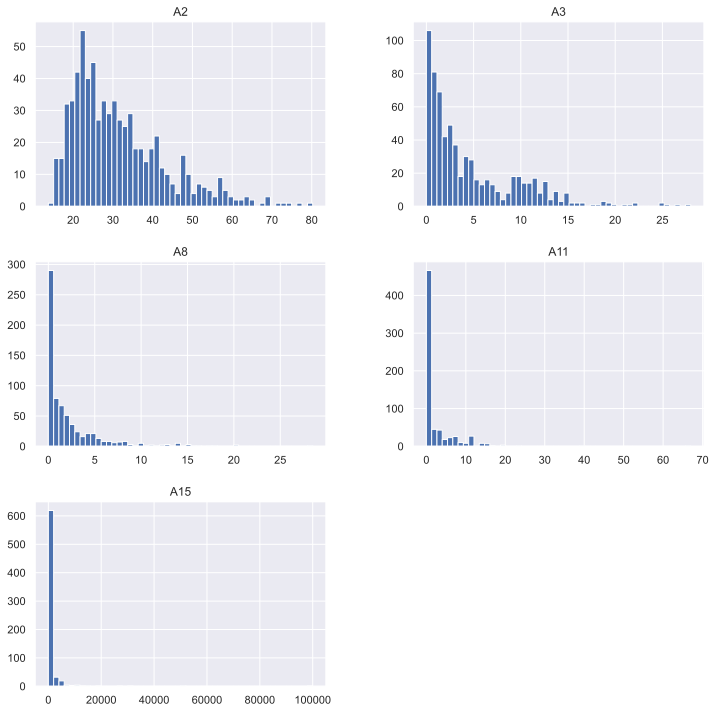

In [27]:
data.hist(bins=50, figsize=(12, 12))
plt.show()

`А2` та `А3` мають асиметричний росподіл. А2 з піком 23. А3 зміщєне до 0. `А8, А11, А15` мають багато 0 та мало інших значень.

Перетворимо `А1, А9, А10, А12, А15, A16` на бінарні фічі.

In [28]:
data['A15'].value_counts()

0       295
1        29
500      10
1000     10
2         9
       ... 
1704      1
857       1
6700      1
2503      1
750       1
Name: A15, Length: 240, dtype: int64

In [29]:
def bin_change(row):
    if row == 0:
        return row
    else:
        return 1

In [30]:
data['A15'] = data['A15'].apply(lambda x : bin_change(x))

In [31]:
le = LabelEncoder()

data['A1'] = le.fit_transform(data['A1'])
data['A9'] = le.fit_transform(data['A9'])
data['A10'] = le.fit_transform(data['A10'])
data['A12'] = le.fit_transform(data['A12'])
data['A16'] = le.fit_transform(data['A16'])

In [32]:
data

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,30.828125,0.000,u,g,w,v,1.25,1,1,1,0,g,00202,0,0
1,0,58.656250,4.460,u,g,q,h,3.04,1,1,6,0,g,00043,1,0
2,0,24.500000,0.500,u,g,q,h,1.50,1,0,0,0,g,00280,1,0
3,1,27.828125,1.540,u,g,w,v,3.75,1,1,5,1,g,00100,1,0
4,1,20.171875,5.625,u,g,w,v,1.71,1,0,0,0,s,00120,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,21.078125,10.085,y,p,e,h,1.25,0,0,0,0,g,00260,0,1
686,0,22.671875,0.750,u,g,c,v,2.00,0,1,2,1,g,00200,1,1
687,0,25.250000,13.500,y,p,ff,ff,2.00,0,1,1,1,g,00200,1,1
688,1,17.921875,0.205,u,g,aa,v,0.04,0,0,0,0,g,00280,1,1


Закодуємо інше категоріальні фічі `А4, А5, А6, А7, А13, А14` через `BaseNEncoder()`

Виділимо фічі в окремий сет

In [33]:
X_encode = data[['A4', 'A5', 'A6', 'A7', 'A13', 'A14']]

In [34]:
bn = BaseNEncoder(base=4)
X_encode = bn.fit_transform(X_encode)

In [35]:
X_encode

,A4_0,A5_0,A6_0,A6_1,A7_0,A7_1,A13_0,A14_0,A14_1,A14_2,A14_3
0,1,1,0,1,0,1,1,0,0,0,1
1,1,1,0,2,0,2,1,0,0,0,2
2,1,1,0,2,0,2,1,0,0,0,3
3,1,1,0,1,0,1,1,0,0,1,0
4,1,1,0,1,0,1,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
685,2,2,2,3,0,2,1,0,0,3,0
686,1,1,1,3,0,1,1,0,1,0,1
687,2,2,3,1,1,0,1,0,1,0,1
688,1,1,3,0,0,1,1,0,0,0,3


Видалимо з нашого сету старі фічі і додамо нові

In [36]:
data = data.drop(['A4', 'A5', 'A6', 'A7', 'A13', 'A14'], axis=1)

In [37]:
data = pd.concat([data, X_encode], axis="columns")

In [38]:
data

,A1,A2,A3,A8,A9,A10,A11,A12,A15,A16,...,A5_0,A6_0,A6_1,A7_0,A7_1,A13_0,A14_0,A14_1,A14_2,A14_3
0,1,30.828125,0.000,1.25,1,1,1,0,0,0,...,1,0,1,0,1,1,0,0,0,1
1,0,58.656250,4.460,3.04,1,1,6,0,1,0,...,1,0,2,0,2,1,0,0,0,2
2,0,24.500000,0.500,1.50,1,0,0,0,1,0,...,1,0,2,0,2,1,0,0,0,3
3,1,27.828125,1.540,3.75,1,1,5,1,1,0,...,1,0,1,0,1,1,0,0,1,0
4,1,20.171875,5.625,1.71,1,0,0,0,0,0,...,1,0,1,0,1,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,21.078125,10.085,1.25,0,0,0,0,0,1,...,2,2,3,0,2,1,0,0,3,0
686,0,22.671875,0.750,2.00,0,1,2,1,1,1,...,1,1,3,0,1,1,0,1,0,1
687,0,25.250000,13.500,2.00,0,1,1,1,1,1,...,2,3,1,1,0,1,0,1,0,1
688,1,17.921875,0.205,0.04,0,0,0,0,1,1,...,1,3,0,0,1,1,0,0,0,3


Кореляція фіч

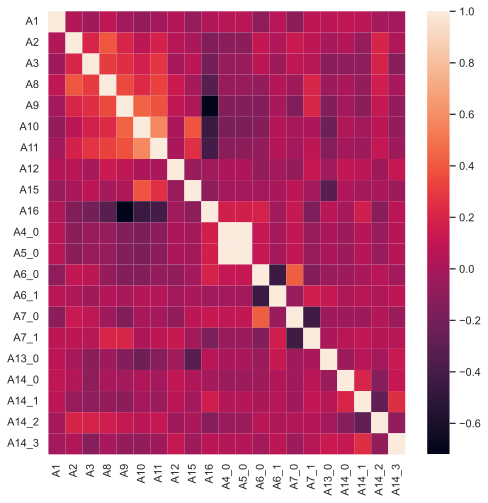

In [39]:
sns.set (rc = {'figure.figsize':(8, 8)})
corr_matrix = data.corr()
sns.heatmap(corr_matrix);

Бачимо що деякі значеня корелюють між собою. Саме `А5_0-А4_0`. Проте можливо це випадкова кореляція після кодуваня фіч. Спробуємо навичти дерево без видаленя, а якщо результат буде незадовільний, то видалемо

---
<a name="4"/>

### 4. Маштабування фіч
[зміст](#0)

Для побудови дерев рішень маштабувати фічі не будемо.

Сплітимо датасет на фічі та тарег

In [40]:
X = data.drop('A16', axis=1).values
y = data['A16'].copy().values

---
<a name="5"/>

### 5. Поділ датасету на train, valid, test
[зміст](#0)

In [41]:
# Функція спліту даних
def data_split_of_parts(X, y, test_size, valid_size=0):
    X_tr_val, X_test, y_tr_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    if valid_size != 0:
        X_train, X_valid, y_train, y_valid = train_test_split(X_tr_val, y_tr_val, test_size=valid_size, random_state=42)
        return X_train, X_valid, X_test, y_train, y_valid, y_test

    else:
        return X_tr_val, X_test, y_tr_val, y_test

In [42]:
X_train, X_valid, X_test, y_train, y_valid, y_test =  data_split_of_parts(X, y, 0.2, 0.3)

---
<a name="6"/>

### 6. Тренування базової моделі(гіперпараметри=дефолтні)
[зміст](#0)

In [43]:
clf = DecisionTreeClassifier(random_state=42)

In [44]:
data_model_default = clf.fit(X_train, y_train)

In [45]:
y_pred_default = data_model_default.predict(X_test)

In [46]:
data_model_default.score(X_test, y_test)

0.782608695652174

---
<a name="7"/>

### 7. Підбір гіперпараметрів
[зміст](#0)

In [47]:
dt_parameters = {'criterion': ('gini', 'entropy', 'log_loss'),
                 'splitter': ('best', 'random'),
                 'max_features': (None, 'sqrt', 'log2', 4, 8, 12,20),
                 'min_samples_split': [2,3,4],
                 'random_state': [42,]}

In [48]:
clf_bp = DecisionTreeClassifier()
clt_model_bp = GridSearchCV(clf_bp, dt_parameters)
clt_model_bp = clt_model_bp.fit(X_valid, y_valid)

In [49]:
clt_model_bp.score(X_test, y_test)

0.8260869565217391

In [50]:
y_pred_bp = clt_model_bp.predict(X_test)

---
<a name="8"/>

### 8. Оцінка результатів
[зміст](#0)

Оцінимо результати навчання базової моделі, та моделі з підбором гіперпараметрів за допомогою `classification_report()`

Дефолтна модель

In [51]:
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        70
           1       0.76      0.81      0.79        68

    accuracy                           0.78       138
   macro avg       0.78      0.78      0.78       138
weighted avg       0.78      0.78      0.78       138



Модель з підібраними гіперпараметрами

In [52]:
clt_model_bp.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_features=12,
                       min_samples_split=3, random_state=42, splitter='random')

In [53]:
print(classification_report(y_test, y_pred_bp))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82        70
           1       0.78      0.90      0.84        68

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138



### Висновок

Бачимо що recall для 1го класу і дефолтна і підібрана модель показують однаковий, однак precision, f1-score та загальне accuracy краще у моделі з підібраними гіперпараметрами. Загалом модель навчилась добре і має загальний score більше за `0.8`.

### Дякую за увагу =)